This is a test notebook comparing the error of the approximation of the volume of window using:

    1- Basic MC with a Poisson point process
    2- MC with Pushed point process
    3- Delyon and Portier leave one out MC estimator
    4- Delyon and Portier corrected leave one out MC estimator

To do: 
    
    1- Approximate Delyon and Portier bandwidth parameter using their approach
    2- Plot the mean square error instead of the standard deviations since Delyon and Portier MC are not unbiased
    3- Mimic Delyon and Portier strategy used to find the bandwidth parameter to find the parameters of push (math:`\epsilon` and t)
    4- test with another oscillating function

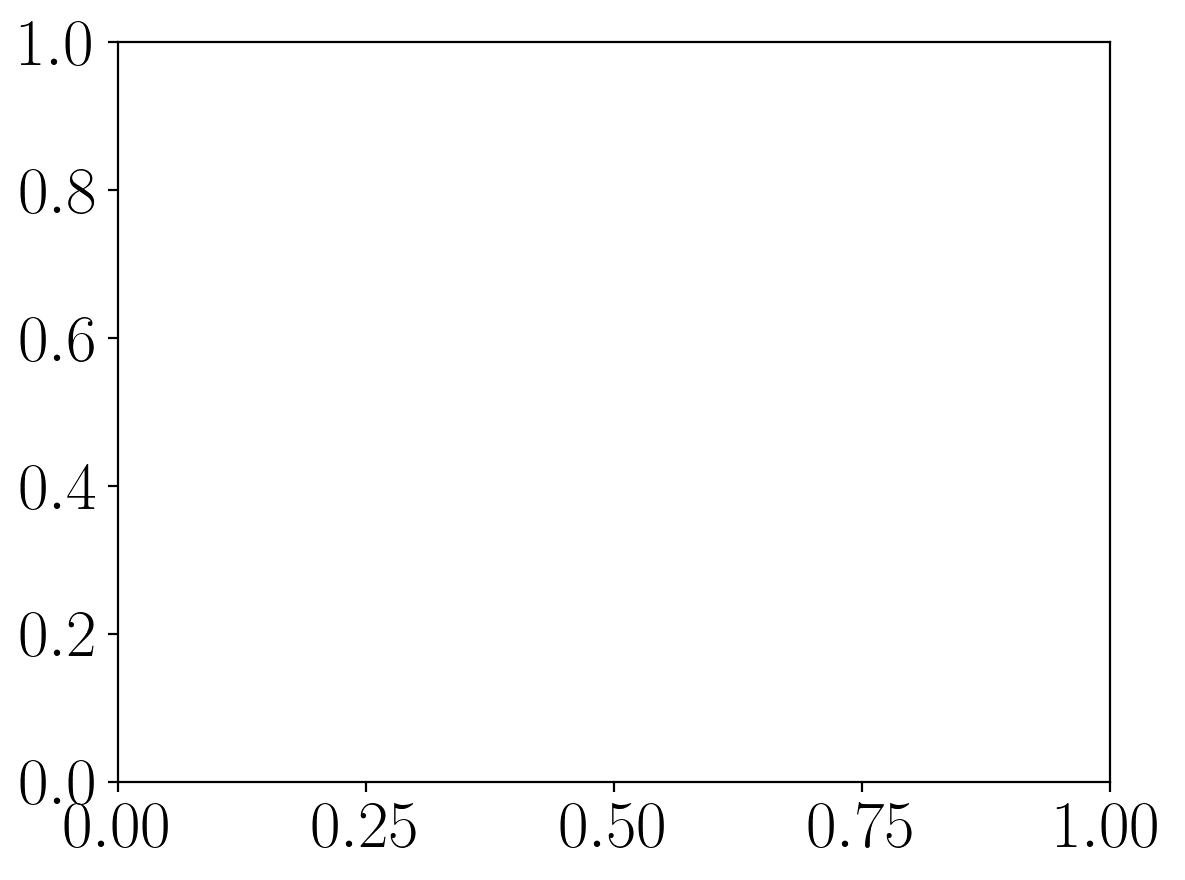

In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

# make plots look nice
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24
plt.rc('axes', labelsize=22)
plt.rc('legend', fontsize=12)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

In [2]:
# to delete this cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format='retina'
import os
import sys
sys.path.insert(0, os.path.abspath('../src/'))

In [3]:
from sklearn.linear_model import LinearRegression

def regression_line(intensity, std):
    log_intensity = np.log([intensity]).T
    log_std = np.log([std]).T
    std_reg = LinearRegression().fit(log_intensity, log_std)
    return log_intensity*std_reg.coef_ + std_reg.intercept_
    

def err_mc(mc):
    return [e[0] for e in mc]
def std_mc(mc):
    return [e[1] for e in mc]

In [ ]:
from GPPY.numerical_integration import monte_carlo_integration, delyon_portier_integration
def mc_result(f, point_pattern, weights, exact_int, approx_type="MC", correction=False, bandwidth=1.5):
    if approx_type == "MC":
        mc = [monte_carlo_integration(f, p.points, weights) for p in point_pattern]
    else :
        mc = [delyon_portier_integration(f, p.points, bandwidth, correction) for p in point_pattern]
    error = exact_int - np.array(mc)
    std = stat.stdev(mc)
    return error, std


In [67]:
from structure_factor.spatial_windows import BallWindow, BoxWindow, UnitBallWindow

#Indicator of the unit ball
def indicator(x, window):
    return np.array([int(window.indicator_function(p) == True) for p in x])

def f1(x):
    d = x.shape[1]
    support = BallWindow(center=[0]*d, radius=1)
    return indicator(x, support)
def exact_integration_f1(d):
    return UnitBallWindow(center=[0]*d).volume

def f2(x):
    support = BoxWindow([[0, 1]]*d)
    return np.product(2*np.sin(np.pi*x)**2, axis=1)*indicator(x, support)

def exact_integration_f2(d):
    return 1
    


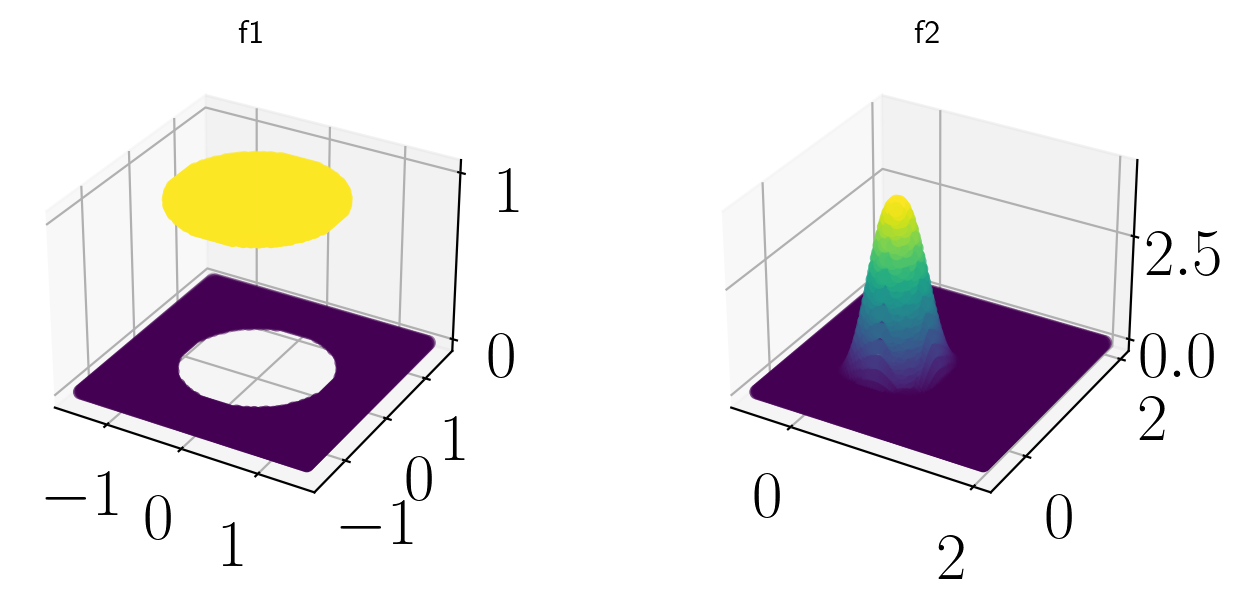

In [70]:
import matplotlib.pyplot as plt
x = np.linspace(-1.5, 1.5, 80)
y = np.linspace(-0.5, 2, 80)
X, Y = np.meshgrid(x, x)
xx = np.array([X.ravel(), Y.ravel()]).T
X2, Y2 = np.meshgrid(y, y)
yy = np.array([X2.ravel(), Y2.ravel()]).T
z_1 = f1(xx)
z_2 = f2(yy)

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(X.ravel(), Y.ravel(), z_1, c=z_1)
ax.set_title("f1")
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(X2.ravel(), Y2.ravel(), z_2, c=z_2)
ax.set_title("f2")
plt.show()

## d=2

In [72]:
from structure_factor.point_processes import HomogeneousPoissonPointProcess

d = 2
window_simu = BallWindow(center=[0]*d, radius=6)
a = HomogeneousPoissonPointProcess(5)
b = a.generate_point_pattern(window=window_simu) 
c = b.points 
b.restrict_to_window

<bound method PointPattern.restrict_to_window of <structure_factor.point_pattern.PointPattern object at 0x7fb7af2b15e0>>

In [83]:
# Creat a poisson point process
import matplotlib.pyplot as plt
import numpy as np
import statistics as stat
import time

from structure_factor.point_processes import HomogeneousPoissonPointProcess
from structure_factor.point_pattern import PointPattern
from GPPY.gravity_point_process import GravityPointProcess

d = 2
window_simu = BallWindow(center=[0]*d, radius=6) #simulation window
window_samp = BallWindow(center=[0]*d, radius=3) #restriction window for sampling
v_window_samp = window_samp.volume #volume sampling window
samples_nb = 30

#mc lists
mc_poisson1, mc_push1, mc_dl1, mc_dl_c1 = [], [], [], []
mc_poisson2, mc_push2, mc_dl2, mc_dl_c2 = [], [], [], []

#intensity list
intensity = [10, 20, 30, 40, 50, 60, 70, 75, 80]

for i in intensity:
    print("i=", i, ", N ALL=", i*window_simu.volume, ", N sample=", i*v_window_samp)
    poisson = HomogeneousPoissonPointProcess(i)
    poisson_pp = [poisson.generate_point_pattern(window=window_simu) for _ in range(samples_nb)]
    gpp = [GravityPointProcess(p) for p in poisson_pp]
    t = time.time()
    if __name__ == "__main__":
        push_pp = [g.pushed_point_pattern(epsilon=g.epsilon_critical) for g in gpp]
    print("time push:", time.time() - t)
    t = time.time()
    
    #Samples:
    poisson_pp_samp = [p.restrict_to_window(window_samp) for p in poisson_pp]
    push_pp_samp = [s[0].restrict_to_window(window_samp) for s in push_pp]
    
    #MC poisson
    mc_poisson1.append( mc_result(f1, poisson_pp_samp, v_window_samp, exact_integration_f1(d)))
    mc_poisson2.append(mc_result(f2, poisson_pp_samp, v_window_samp, exact_integration_f2(d)))
    print("time MC poisson:", time.time() - t)
    t = time.time()
    #MC push
    mc_push1.append(mc_result(f1, push_pp_samp, v_window_samp, exact_integration_f1(d)))
    mc_push2.append(mc_result(f2, push_pp_samp, v_window_samp, exact_integration_f2(d)))
    print("time MC push:", time.time() - t)
    t = time.time()
    #MC delpor
    mc_dl1.append(mc_result(f1, poisson_pp_samp, v_window_samp, exact_integration_f1(d), approx_type="DP"))
    mc_dl2.append(mc_result(f2, poisson_pp_samp, v_window_samp, exact_integration_f2(d), approx_type="DP"))
    print("time MC dl:", time.time() - t)
    t = time.time()
    #MC delpor corrected
    mc_dl_c1.append(mc_result(f1, poisson_pp_samp, v_window_samp, exact_integration_f1(d), approx_type="DP", correction=True))
    mc_dl_c2.append(mc_result(f2, poisson_pp_samp, v_window_samp, exact_integration_f2(d), approx_type="DP", correction=True))
    print("time MC dl corrected:", time.time() - t)
    t = time.time()


i= 10 , N ALL= 1130.9733552923256 , N sample= 282.7433388230814
time push: 127.57537889480591
time MC poisson: 0.18404412269592285
time MC push: 0.19894194602966309
time MC dl: 5.4936909675598145
time MC dl corrected: 16.09992289543152
i= 20 , N ALL= 2261.946710584651 , N sample= 565.4866776461628
time push: 104.34170699119568
time MC poisson: 0.39670491218566895
time MC push: 0.36852312088012695
time MC dl: 20.57275128364563
time MC dl corrected: 59.25615692138672
i= 30 , N ALL= 3392.9200658769764 , N sample= 848.2300164692441
time push: 105.75994491577148
time MC poisson: 0.5758001804351807
time MC push: 0.5415389537811279
time MC dl: 44.690223932266235
time MC dl corrected: 135.73638129234314
i= 40 , N ALL= 4523.893421169302 , N sample= 1130.9733552923256
time push: 113.31787610054016
time MC poisson: 0.7355620861053467
time MC push: 0.7172081470489502
time MC dl: 73.70378494262695
time MC dl corrected: 216.62831115722656
i= 50 , N ALL= 5654.8667764616275 , N sample= 1413.7166941154

In [91]:
# slope
log_intensity = np.log([intensity]).T

print("poisson", LinearRegression().fit(log_intensity, np.log(std_mc(mc_poisson1))).coef_)
print("poisson", LinearRegression().fit(log_intensity, np.log(std_mc(mc_poisson2))).coef_)
print("push", LinearRegression().fit(log_intensity, np.log(std_mc(mc_push1))).coef_)
print("push", LinearRegression().fit(log_intensity, np.log(std_mc(mc_push2))).coef_)
print("delpor", LinearRegression().fit(log_intensity, np.log(std_mc(mc_dl1))).coef_)
print("delpor", LinearRegression().fit(log_intensity, np.log(std_mc(mc_dl2))).coef_)
print("delpor", LinearRegression().fit(log_intensity, np.log(std_mc(mc_dl_c1))).coef_)
print("delpor_c", LinearRegression().fit(log_intensity, np.log(std_mc(mc_dl_c2))).coef_)



poisson [-0.58923474]
poisson [-0.48508561]
push [-0.52889823]
push [-0.51159661]
delpor [-0.66824749]
delpor [-0.49132359]
delpor [-0.64666098]
delpor_c [-0.46835156]


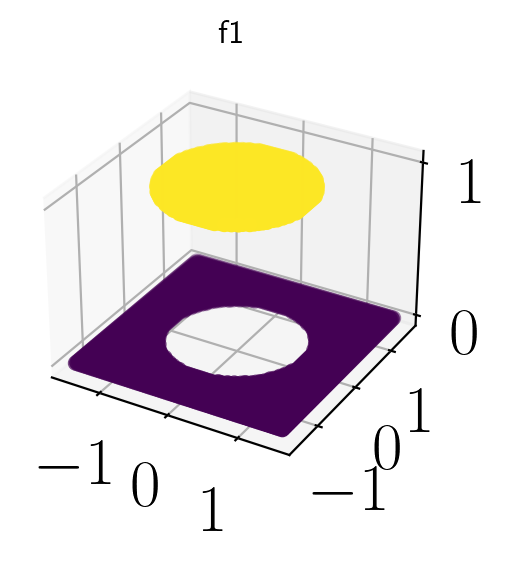

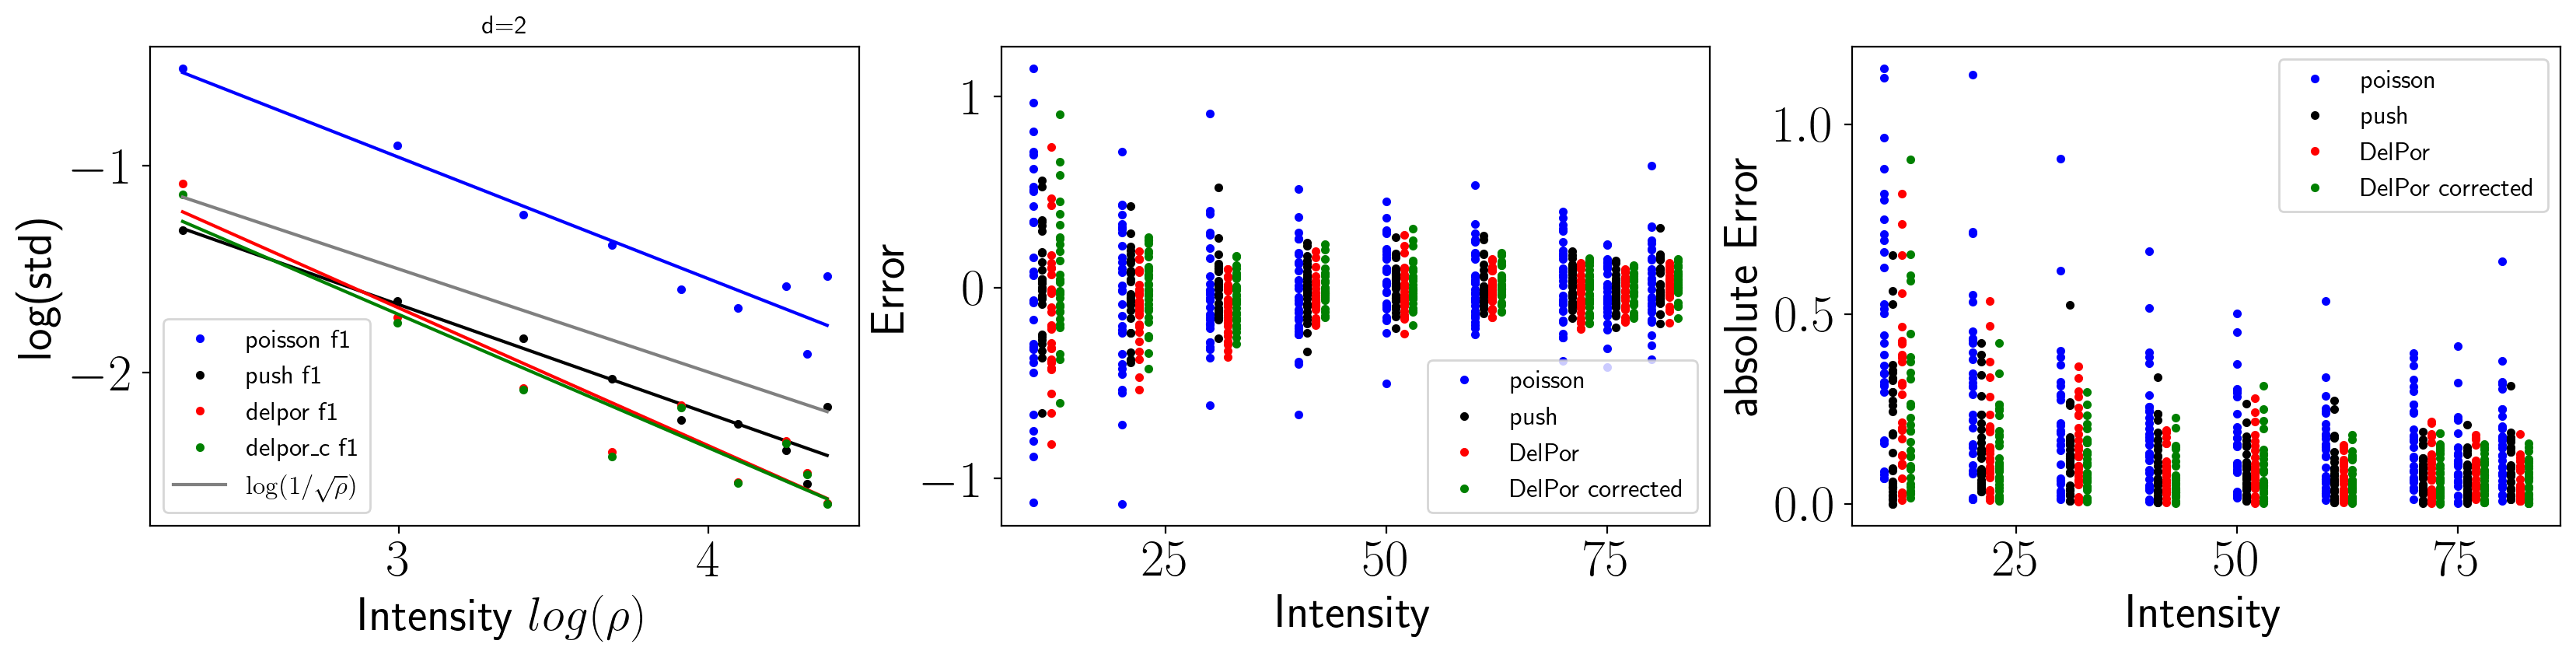

In [89]:
import matplotlib.pyplot as plt

log_intensity = np.log([intensity]).T

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(X.ravel(), Y.ravel(), z_1, c=z_1)
ax.set_title("f1")
plt.show()

#N = np.array(intensity)*volume_simu_window
fig, axis = plt.subplots(1,3, figsize=(20,4))
axis[0].plot(log_intensity, np.log(std_mc(mc_poisson1)), 'b.', label="poisson f1")
axis[0].plot(log_intensity, regression_line(intensity, std_mc(mc_poisson1)), 'b')
axis[0].plot(log_intensity, np.log(std_mc(mc_push1)), 'k.', label="push f1")
axis[0].plot(log_intensity, regression_line(intensity, std_mc(mc_push1)), 'k')
axis[0].plot(log_intensity, np.log(std_mc(mc_dl1)), 'r.', label="delpor f1")
axis[0].plot(log_intensity, regression_line(intensity, std_mc(mc_dl1)), 'r')
axis[0].plot(log_intensity, np.log(std_mc(mc_dl_c1)), 'g.', label="delpor_c f1")
axis[0].plot(log_intensity, regression_line(intensity, std_mc(mc_dl_c1)), 'g')
axis[0].plot(log_intensity, np.log(1/np.sqrt(intensity)), 'grey', label=r"$\log(1/\sqrt{\rho})$")
axis[0].set_title("d=%s" %d)
axis[0].set_xlabel(r"Intensity $log(\rho)$")
axis[0].set_ylabel("log(std)")
axis[0].legend()

axis[1].plot(intensity, err_mc(mc_poisson1), 'b.')
axis[1].plot(intensity[0], err_mc(mc_poisson1)[0][0], 'b.', label="poisson")
axis[1].plot(np.array(intensity) +1, err_mc(mc_push1), 'k.')
axis[1].plot(np.array(intensity[0]) +1, err_mc(mc_push1)[0][0], 'k.', label="push")
axis[1].plot(np.array(intensity) + 2, err_mc(mc_dl1), 'r.')
axis[1].plot(np.array(intensity[1]) +2, err_mc(mc_dl1)[1][0], 'r.', label="DelPor")
axis[1].plot(np.array(intensity) + 3, err_mc(mc_dl_c1), 'g.')
axis[1].plot(np.array(intensity[1]) +3, err_mc(mc_dl_c1)[1][0], 'g.', label="DelPor corrected")
axis[1].set_xlabel("Intensity")
axis[1].set_ylabel("Error")
axis[1].legend()

axis[2].plot(intensity, np.abs(err_mc(mc_poisson1)), 'b.')
axis[2].plot(intensity[0], abs(err_mc(mc_poisson1)[0][0]), 'b.', label="poisson")
axis[2].plot(np.array(intensity) +1, np.abs(err_mc(mc_push1)), 'k.')
axis[2].plot(np.array(intensity[0]) +1, np.abs(err_mc(mc_push1)[0][0]), 'k.', label="push")
axis[2].plot(np.array(intensity) + 2, np.abs(err_mc(mc_dl1)), 'r.')
axis[2].plot(np.array(intensity[1]) +2, np.abs(err_mc(mc_dl1)[1][0]), 'r.', label="DelPor")
axis[2].plot(np.array(intensity) + 3, np.abs(err_mc(mc_dl_c1)), 'g.')
axis[2].plot(np.array(intensity[1]) +3, np.abs(err_mc(mc_dl_c1)[1][0]), 'g.', label="DelPor corrected")
axis[2].set_xlabel("Intensity")
axis[2].set_ylabel("absolute Error")
axis[2].legend()
plt.show()

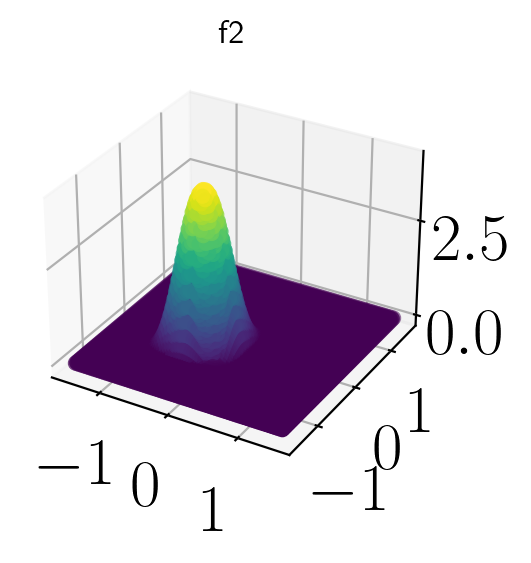

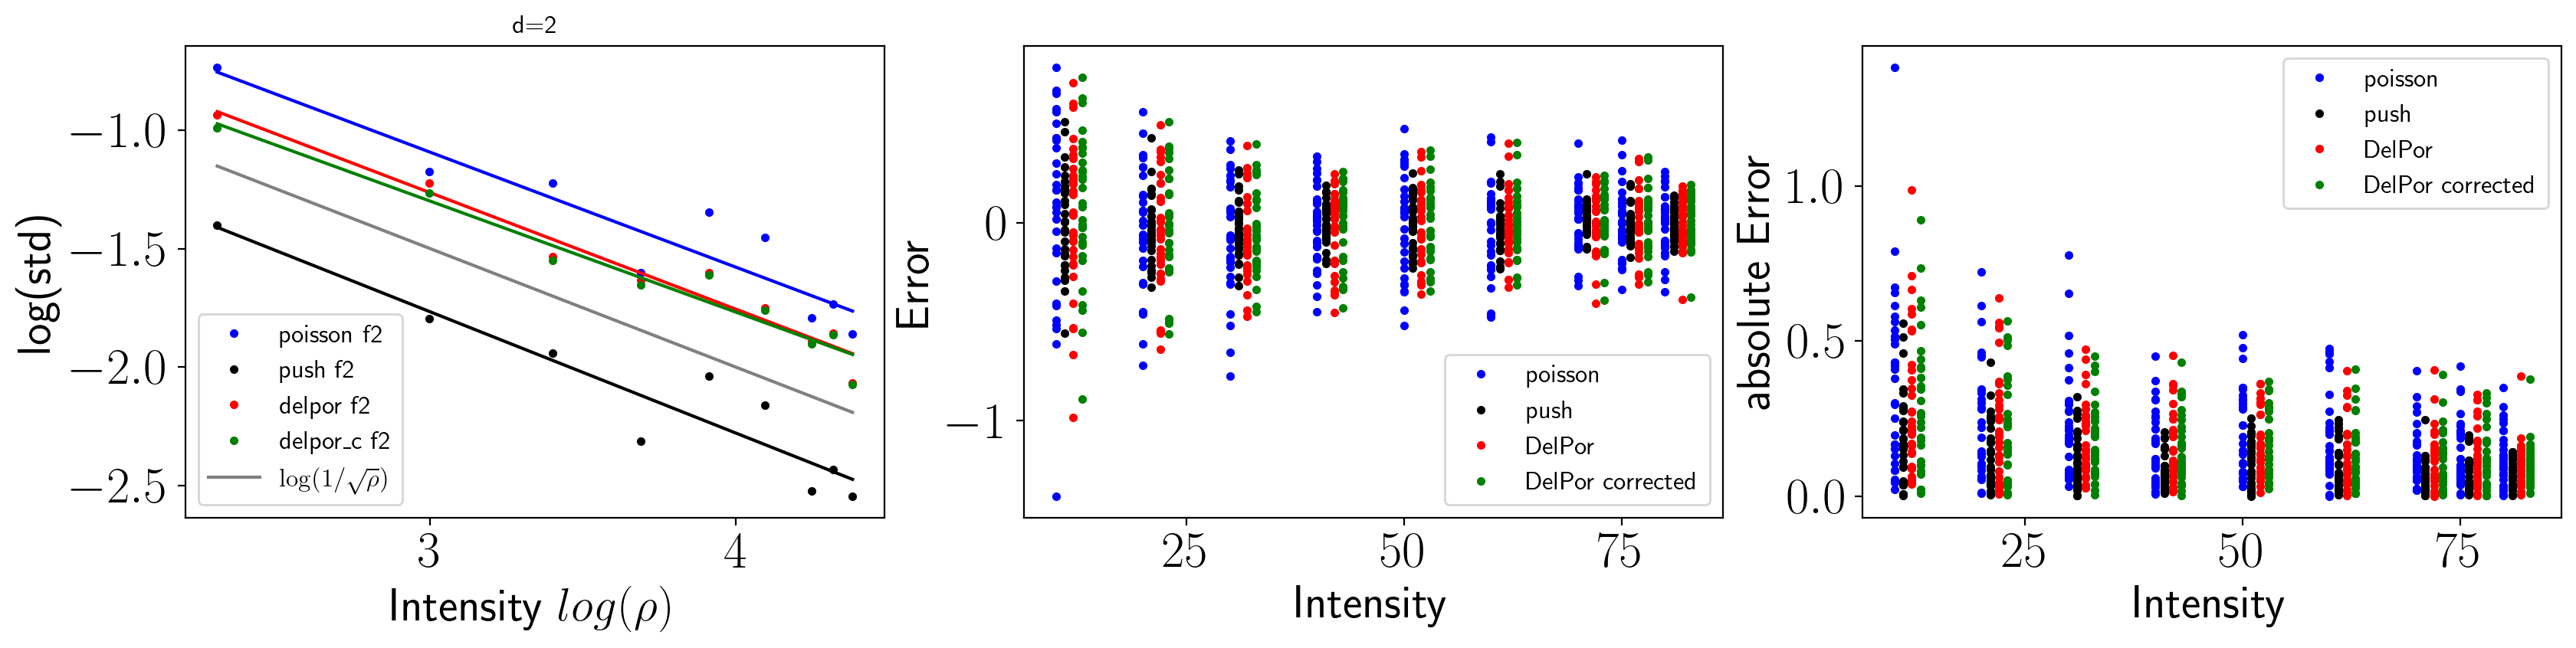

In [90]:
import matplotlib.pyplot as plt

log_intensity = np.log([intensity]).T

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(X.ravel(), Y.ravel(), z_2, c=z_2)
ax.set_title("f2")
plt.show()
#N = np.array(intensity)*volume_simu_window
fig, axis = plt.subplots(1,3, figsize=(20,4))
axis[0].plot(log_intensity, np.log(std_mc(mc_poisson2)), 'b.', label="poisson f2")
axis[0].plot(log_intensity, regression_line(intensity, std_mc(mc_poisson2)), 'b')
axis[0].plot(log_intensity, np.log(std_mc(mc_push2)), 'k.', label="push f2")
axis[0].plot(log_intensity, regression_line(intensity, std_mc(mc_push2)), 'k')
axis[0].plot(log_intensity, np.log(std_mc(mc_dl2)), 'r.', label="delpor f2")
axis[0].plot(log_intensity, regression_line(intensity, std_mc(mc_dl2)), 'r')
axis[0].plot(log_intensity, np.log(std_mc(mc_dl_c2)), 'g.', label="delpor_c f2")
axis[0].plot(log_intensity, regression_line(intensity, std_mc(mc_dl_c2)), 'g')
axis[0].plot(log_intensity, np.log(1/np.sqrt(intensity)), 'grey', label=r"$\log(1/\sqrt{\rho})$")
axis[0].set_title("d=%s" %d)
axis[0].set_xlabel(r"Intensity $log(\rho)$")
axis[0].set_ylabel("log(std)")
axis[0].legend()

axis[1].plot(intensity, err_mc(mc_poisson2), 'b.')
axis[1].plot(intensity[0], err_mc(mc_poisson2)[0][0], 'b.', label="poisson")
axis[1].plot(np.array(intensity) +1, err_mc(mc_push2), 'k.')
axis[1].plot(np.array(intensity[0]) +1, err_mc(mc_push2)[0][0], 'k.', label="push")
axis[1].plot(np.array(intensity) + 2, err_mc(mc_dl2), 'r.')
axis[1].plot(np.array(intensity[1]) +2, err_mc(mc_dl2)[1][0], 'r.', label="DelPor")
axis[1].plot(np.array(intensity) + 3, err_mc(mc_dl_c2), 'g.')
axis[1].plot(np.array(intensity[1]) +3, err_mc(mc_dl_c2)[1][0], 'g.', label="DelPor corrected")
axis[1].set_xlabel("Intensity")
axis[1].set_ylabel("Error")
axis[1].legend()

axis[2].plot(intensity, np.abs(err_mc(mc_poisson2)), 'b.')
axis[2].plot(intensity[0], abs(err_mc(mc_poisson2)[0][0]), 'b.', label="poisson")
axis[2].plot(np.array(intensity) +1, np.abs(err_mc(mc_push2)), 'k.')
axis[2].plot(np.array(intensity[0]) +1, np.abs(err_mc(mc_push2)[0][0]), 'k.', label="push")
axis[2].plot(np.array(intensity) + 2, np.abs(err_mc(mc_dl2)), 'r.')
axis[2].plot(np.array(intensity[1]) +2, np.abs(err_mc(mc_dl2)[1][0]), 'r.', label="DelPor")
axis[2].plot(np.array(intensity) + 3, np.abs(err_mc(mc_dl_c2)), 'g.')
axis[2].plot(np.array(intensity[1]) +3, np.abs(err_mc(mc_dl_c2)[1][0]), 'g.', label="DelPor corrected")
axis[2].set_xlabel("Intensity")
axis[2].set_ylabel("absolute Error")
axis[2].legend()
plt.show()

## d=3

In [93]:
# Creat a poisson point process
import matplotlib.pyplot as plt
import numpy as np
import statistics as stat
import time

from structure_factor.point_processes import HomogeneousPoissonPointProcess
from structure_factor.point_pattern import PointPattern
from GPPY.gravity_point_process import GravityPointProcess

d = 3
window_simu = BallWindow(center=[0]*d, radius=6) #simulation window
window_samp = BallWindow(center=[0]*d, radius=3) #restriction window for sampling
v_window_samp = window_samp.volume #volume sampling window
samples_nb = 30

#mc lists
mc_poisson1, mc_push1, mc_dl1, mc_dl_c1 = [], [], [], []
mc_poisson2, mc_push2, mc_dl2, mc_dl_c2 = [], [], [], []

#intensity list
intensity = [5, 7, 10, 15, 20, 25, 28, 30, 35]

for i in intensity:
    print("i=", i, ", N ALL=", i*window_simu.volume, ", N sample=", i*v_window_samp)
    poisson = HomogeneousPoissonPointProcess(i)
    poisson_pp = [poisson.generate_point_pattern(window=window_simu) for _ in range(samples_nb)]
    gpp = [GravityPointProcess(p) for p in poisson_pp]
    t = time.time()
    if __name__ == "__main__":
        push_pp = [g.pushed_point_pattern(epsilon=g.epsilon_critical) for g in gpp]
    print("time push:", time.time() - t)
    t = time.time()
    
    #Samples:
    poisson_pp_samp = [p.restrict_to_window(window_samp) for p in poisson_pp]
    push_pp_samp = [s[0].restrict_to_window(window_samp) for s in push_pp]
    
    #MC poisson
    mc_poisson1.append( mc_result(f1, poisson_pp_samp, v_window_samp, exact_integration_f1(d)))
    mc_poisson2.append(mc_result(f2, poisson_pp_samp, v_window_samp, exact_integration_f2(d)))
    print("time MC poisson:", time.time() - t)
    t = time.time()
    #MC push
    mc_push1.append(mc_result(f1, push_pp_samp, v_window_samp, exact_integration_f1(d)))
    mc_push2.append(mc_result(f2, push_pp_samp, v_window_samp, exact_integration_f2(d)))
    print("time MC push:", time.time() - t)
    t = time.time()
    #MC delpor
    mc_dl1.append(mc_result(f1, poisson_pp_samp, v_window_samp, exact_integration_f1(d), approx_type="DP"))
    mc_dl2.append(mc_result(f2, poisson_pp_samp, v_window_samp, exact_integration_f2(d), approx_type="DP"))
    print("time MC dl:", time.time() - t)
    t = time.time()
    #MC delpor corrected
    mc_dl_c1.append(mc_result(f1, poisson_pp_samp, v_window_samp, exact_integration_f1(d), approx_type="DP", correction=True))
    mc_dl_c2.append(mc_result(f2, poisson_pp_samp, v_window_samp, exact_integration_f2(d), approx_type="DP", correction=True))
    print("time MC dl corrected:", time.time() - t)
    t = time.time()


i= 5 , N ALL= 4523.893421169301 , N sample= 565.4866776461627
time push: 112.40143179893494
time MC poisson: 0.3742520809173584
time MC push: 0.3958401679992676
time MC dl: 20.224899768829346
time MC dl corrected: 58.10943412780762
i= 7 , N ALL= 6333.450789637022 , N sample= 791.6813487046278
time push: 123.21065497398376
time MC poisson: 0.521270751953125
time MC push: 0.527346134185791
time MC dl: 38.551531076431274
time MC dl corrected: 112.81873106956482
i= 10 , N ALL= 9047.786842338603 , N sample= 1130.9733552923253
time push: 146.47108817100525
time MC poisson: 0.7703061103820801
time MC push: 0.6999900341033936
time MC dl: 75.61844491958618
time MC dl corrected: 222.28372621536255
i= 15 , N ALL= 13571.680263507904 , N sample= 1696.460032938488
time push: 236.7663381099701
time MC poisson: 1.178576946258545
time MC push: 1.0914690494537354
time MC dl: 184.1370451450348
time MC dl corrected: 526.087682723999
i= 20 , N ALL= 18095.573684677205 , N sample= 2261.9467105846506
time pus

KeyboardInterrupt: 

In [95]:
# slope
log_intensity = np.log([intensity]).T

print("poisson", LinearRegression().fit(log_intensity[:6], np.log(std_mc(mc_poisson1))).coef_)
print("poisson", LinearRegression().fit(log_intensity[:6], np.log(std_mc(mc_poisson2))).coef_)
print("push", LinearRegression().fit(log_intensity[:6], np.log(std_mc(mc_push1))).coef_)
print("push", LinearRegression().fit(log_intensity[:6], np.log(std_mc(mc_push2))).coef_)
print("delpor", LinearRegression().fit(log_intensity[:6], np.log(std_mc(mc_dl1))).coef_)
print("delpor", LinearRegression().fit(log_intensity[:6], np.log(std_mc(mc_dl2))).coef_)
print("delpor", LinearRegression().fit(log_intensity[:6], np.log(std_mc(mc_dl_c1))).coef_)
print("delpor_c", LinearRegression().fit(log_intensity[:5], np.log(std_mc(mc_dl_c2))).coef_)



poisson [-0.41285486]
poisson [-0.34072221]
push [-0.46354197]
push [-0.50962603]
delpor [-0.43046275]
delpor [-0.29083166]
delpor [-0.45088659]
delpor_c [-0.27497358]


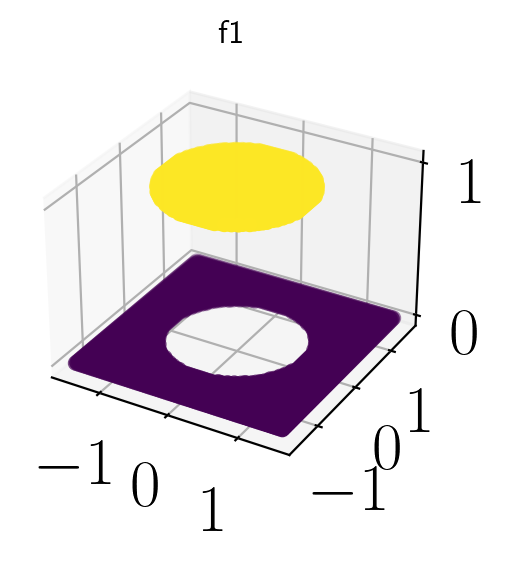

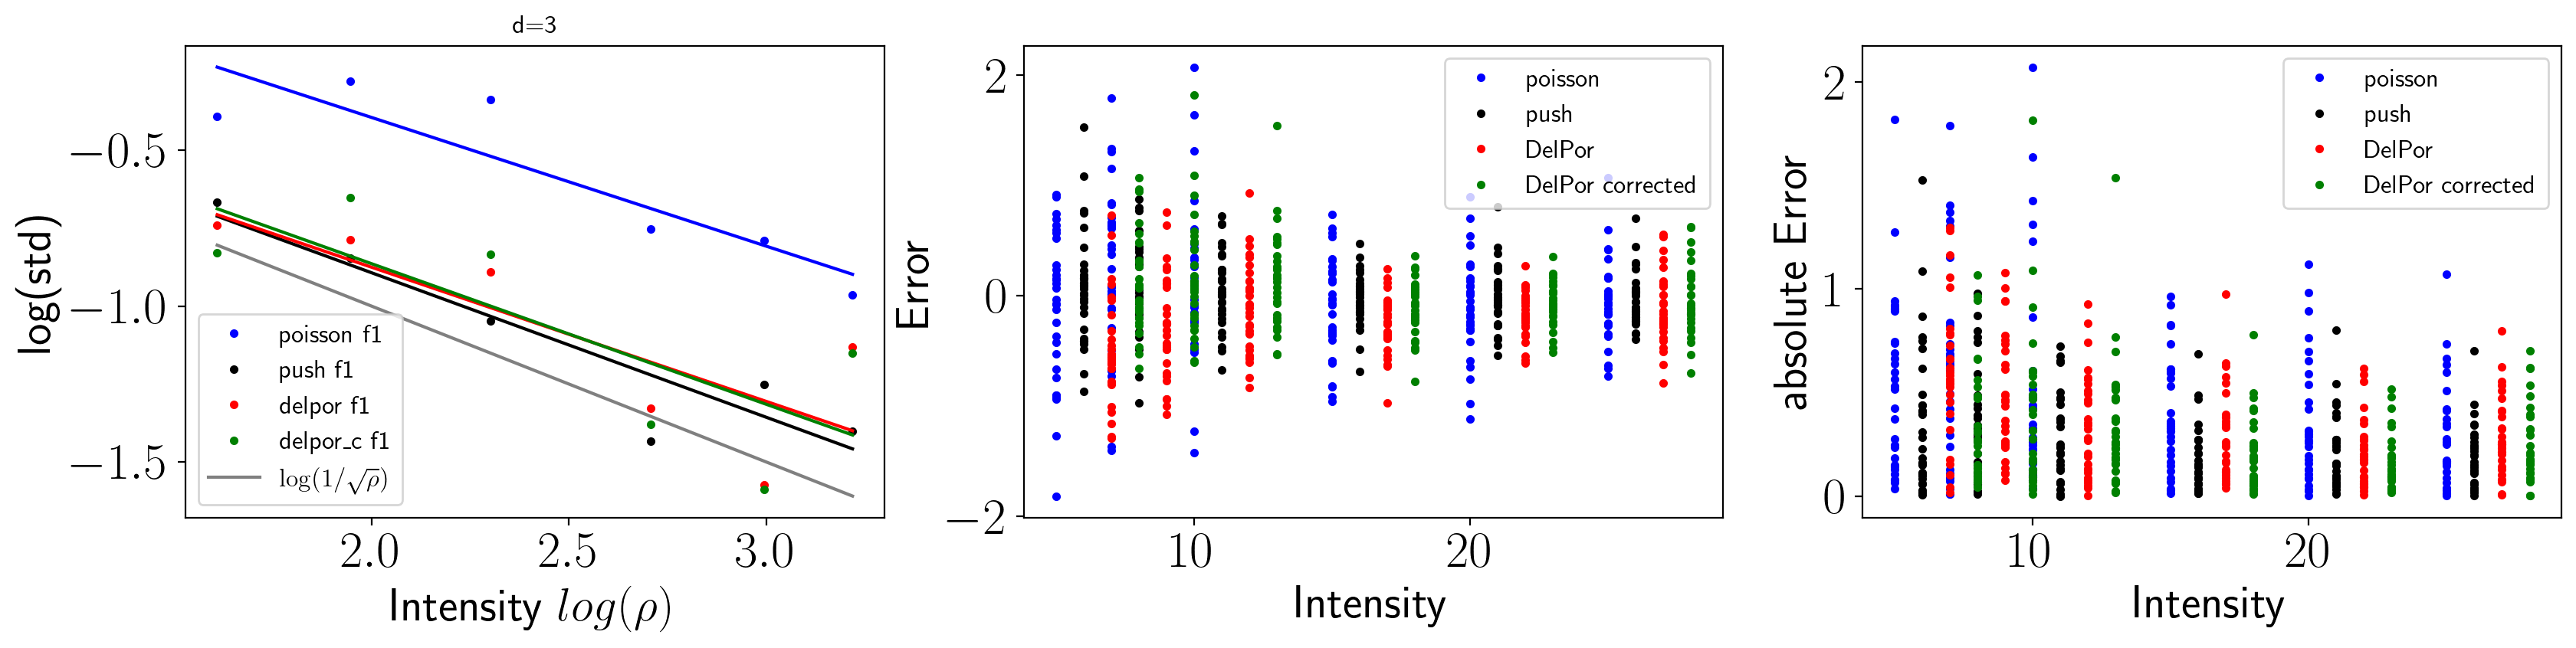

In [98]:
import matplotlib.pyplot as plt

log_intensity = np.log([intensity]).T

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(X.ravel(), Y.ravel(), z_1, c=z_1)
ax.set_title("f1")
plt.show()

#N = np.array(intensity)*volume_simu_window
fig, axis = plt.subplots(1,3, figsize=(20,4))
axis[0].plot(log_intensity[:6], np.log(std_mc(mc_poisson1)), 'b.', label="poisson f1")
axis[0].plot(log_intensity[:6], regression_line(intensity[:6], std_mc(mc_poisson1)), 'b')
axis[0].plot(log_intensity[:6], np.log(std_mc(mc_push1)), 'k.', label="push f1")
axis[0].plot(log_intensity[:6], regression_line(intensity[:6], std_mc(mc_push1)), 'k')
axis[0].plot(log_intensity[:6], np.log(std_mc(mc_dl1)), 'r.', label="delpor f1")
axis[0].plot(log_intensity[:6], regression_line(intensity[:6], std_mc(mc_dl1)), 'r')
axis[0].plot(log_intensity[:6], np.log(std_mc(mc_dl_c1)), 'g.', label="delpor_c f1")
axis[0].plot(log_intensity[:6], regression_line(intensity[:6], std_mc(mc_dl_c1)), 'g')
axis[0].plot(log_intensity[:6], np.log(1/np.sqrt(intensity[:6])), 'grey', label=r"$\log(1/\sqrt{\rho})$")
axis[0].set_title("d=%s" %d)
axis[0].set_xlabel(r"Intensity $log(\rho)$")
axis[0].set_ylabel("log(std)")
axis[0].legend()

axis[1].plot(intensity[:6], err_mc(mc_poisson1), 'b.')
axis[1].plot(intensity[0], err_mc(mc_poisson1)[0][0], 'b.', label="poisson")
axis[1].plot(np.array(intensity[:6]) +1, err_mc(mc_push1), 'k.')
axis[1].plot(np.array(intensity[0]) +1, err_mc(mc_push1)[0][0], 'k.', label="push")
axis[1].plot(np.array(intensity[:6]) + 2, err_mc(mc_dl1), 'r.')
axis[1].plot(np.array(intensity[1]) +2, err_mc(mc_dl1)[1][0], 'r.', label="DelPor")
axis[1].plot(np.array(intensity[:6]) + 3, err_mc(mc_dl_c1), 'g.')
axis[1].plot(np.array(intensity[1]) +3, err_mc(mc_dl_c1)[1][0], 'g.', label="DelPor corrected")
axis[1].set_xlabel("Intensity")
axis[1].set_ylabel("Error")
axis[1].legend()

axis[2].plot(intensity[:6], np.abs(err_mc(mc_poisson1)), 'b.')
axis[2].plot(intensity[0], abs(err_mc(mc_poisson1)[0][0]), 'b.', label="poisson")
axis[2].plot(np.array(intensity[:6]) +1, np.abs(err_mc(mc_push1)), 'k.')
axis[2].plot(np.array(intensity[0]) +1, np.abs(err_mc(mc_push1)[0][0]), 'k.', label="push")
axis[2].plot(np.array(intensity[:6]) + 2, np.abs(err_mc(mc_dl1)), 'r.')
axis[2].plot(np.array(intensity[1]) +2, np.abs(err_mc(mc_dl1)[1][0]), 'r.', label="DelPor")
axis[2].plot(np.array(intensity[:6]) + 3, np.abs(err_mc(mc_dl_c1)), 'g.')
axis[2].plot(np.array(intensity[1]) +3, np.abs(err_mc(mc_dl_c1)[1][0]), 'g.', label="DelPor corrected")
axis[2].set_xlabel("Intensity")
axis[2].set_ylabel("absolute Error")
axis[2].legend()
plt.show()

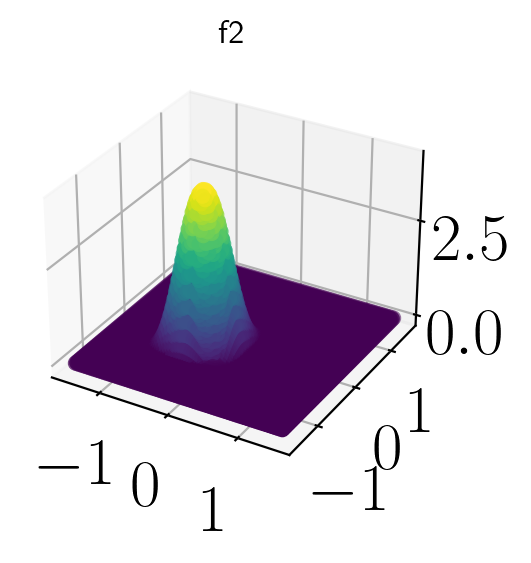

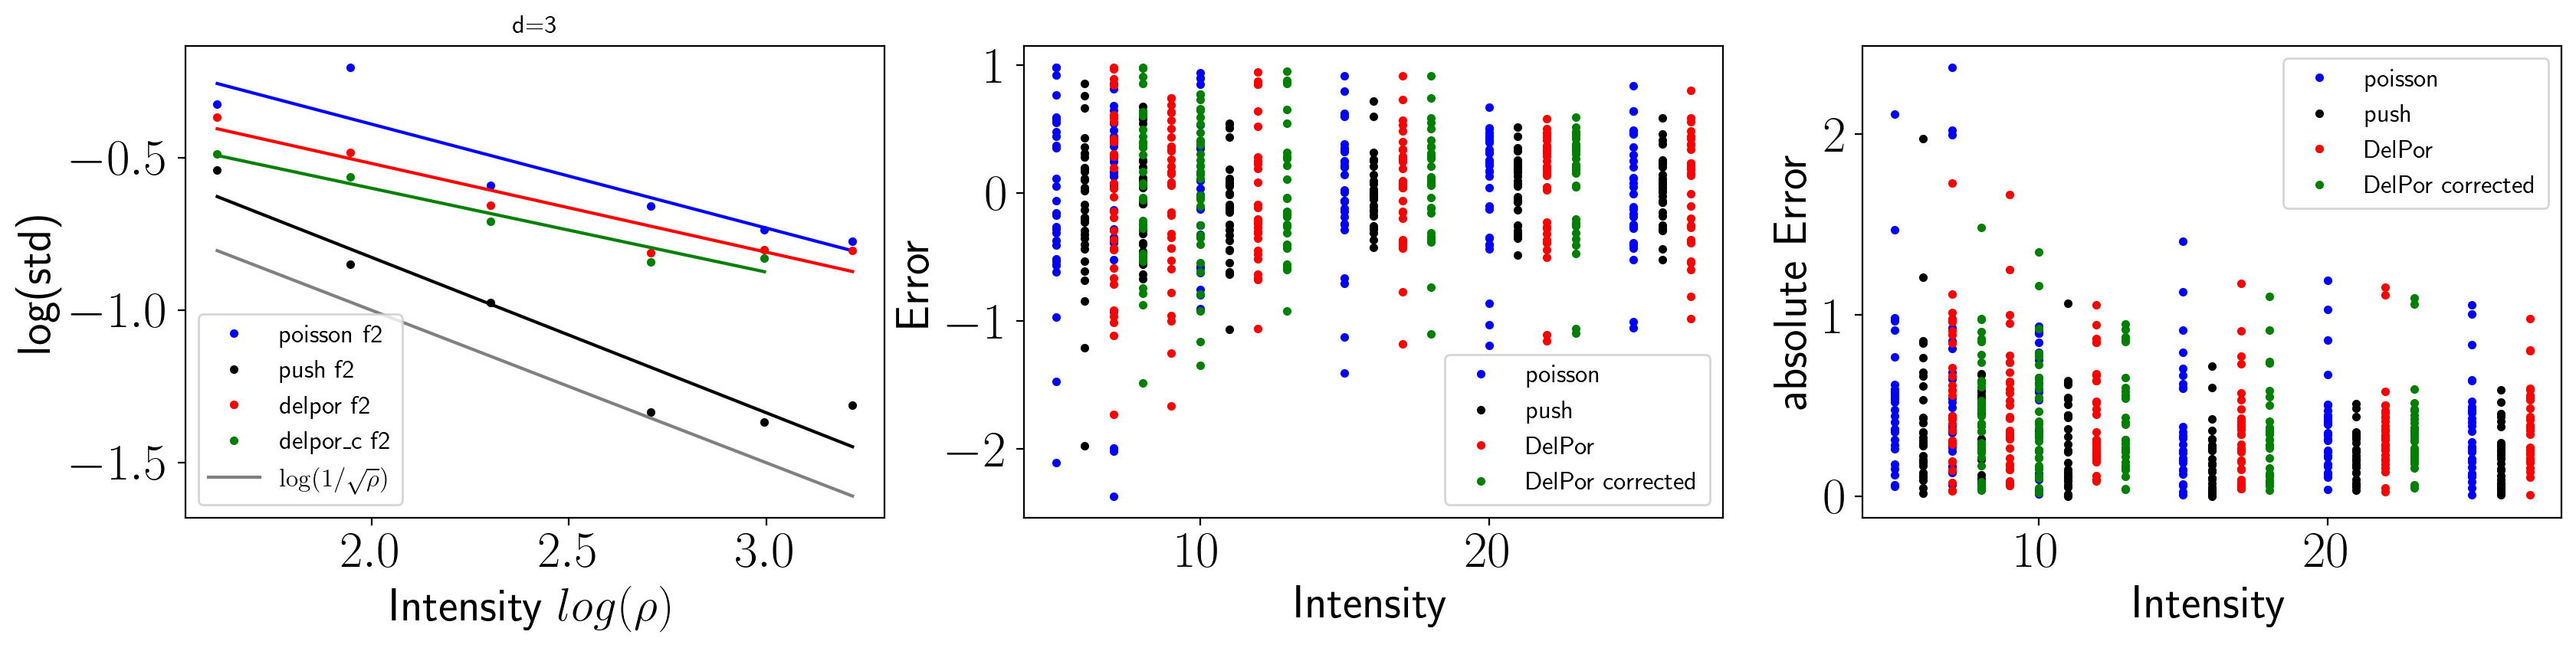

In [100]:
import matplotlib.pyplot as plt

log_intensity = np.log([intensity]).T

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(X.ravel(), Y.ravel(), z_2, c=z_2)
ax.set_title("f2")
plt.show()
#N = np.array(intensity)*volume_simu_window
fig, axis = plt.subplots(1,3, figsize=(20,4))
axis[0].plot(log_intensity[:6], np.log(std_mc(mc_poisson2)), 'b.', label="poisson f2")
axis[0].plot(log_intensity[:6], regression_line(intensity[:6], std_mc(mc_poisson2)), 'b')
axis[0].plot(log_intensity[:6], np.log(std_mc(mc_push2)), 'k.', label="push f2")
axis[0].plot(log_intensity[:6], regression_line(intensity[:6], std_mc(mc_push2)), 'k')
axis[0].plot(log_intensity[:6], np.log(std_mc(mc_dl2)), 'r.', label="delpor f2")
axis[0].plot(log_intensity[:6], regression_line(intensity[:6], std_mc(mc_dl2)), 'r')
axis[0].plot(log_intensity[:5], np.log(std_mc(mc_dl_c2)), 'g.', label="delpor_c f2")
axis[0].plot(log_intensity[:5], regression_line(intensity[:5], std_mc(mc_dl_c2)), 'g')
axis[0].plot(log_intensity[:6], np.log(1/np.sqrt(intensity[:6])), 'grey', label=r"$\log(1/\sqrt{\rho})$")
axis[0].set_title("d=%s" %d)
axis[0].set_xlabel(r"Intensity $log(\rho)$")
axis[0].set_ylabel("log(std)")
axis[0].legend()

axis[1].plot(intensity[:6], err_mc(mc_poisson2), 'b.')
axis[1].plot(intensity[0], err_mc(mc_poisson2)[0][0], 'b.', label="poisson")
axis[1].plot(np.array(intensity[:6]) +1, err_mc(mc_push2), 'k.')
axis[1].plot(np.array(intensity[0]) +1, err_mc(mc_push2)[0][0], 'k.', label="push")
axis[1].plot(np.array(intensity[:6]) + 2, err_mc(mc_dl2), 'r.')
axis[1].plot(np.array(intensity[1]) +2, err_mc(mc_dl2)[1][0], 'r.', label="DelPor")
axis[1].plot(np.array(intensity[:5]) + 3, err_mc(mc_dl_c2), 'g.')
axis[1].plot(np.array(intensity[1]) +3, err_mc(mc_dl_c2)[1][0], 'g.', label="DelPor corrected")
axis[1].set_xlabel("Intensity")
axis[1].set_ylabel("Error")
axis[1].legend()

axis[2].plot(intensity[:6], np.abs(err_mc(mc_poisson2)), 'b.')
axis[2].plot(intensity[0], abs(err_mc(mc_poisson2)[0][0]), 'b.', label="poisson")
axis[2].plot(np.array(intensity[:6]) +1, np.abs(err_mc(mc_push2)), 'k.')
axis[2].plot(np.array(intensity[0]) +1, np.abs(err_mc(mc_push2)[0][0]), 'k.', label="push")
axis[2].plot(np.array(intensity[:6]) + 2, np.abs(err_mc(mc_dl2)), 'r.')
axis[2].plot(np.array(intensity[1]) +2, np.abs(err_mc(mc_dl2)[1][0]), 'r.', label="DelPor")
axis[2].plot(np.array(intensity[:5]) + 3, np.abs(err_mc(mc_dl_c2)), 'g.')
axis[2].plot(np.array(intensity[1]) +3, np.abs(err_mc(mc_dl_c2)[1][0]), 'g.', label="DelPor corrected")
axis[2].set_xlabel("Intensity")
axis[2].set_ylabel("absolute Error")
axis[2].legend()
plt.show()